# Model building

* ## Load packages and dataset

In [1]:
#%reset

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from collections import Counter

In [3]:
df = pd.read_csv('model_Data_17_Nov.csv')
pd.set_option('display.max_columns', None)


In [4]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

2.9.1


* ## Make sure categorcal

In [5]:

#We make sure that the objects become category again. 
categoryAgain = list(df.select_dtypes(include=['object']))


#We make sure that our category variables are given the dtype, after we have loaded our dataset.
for category in categoryAgain:
    df[category] = df[category].astype('category')

* ## Ordinal variables

In [6]:
ordered_Energy = ['G', 'F', 'E', 'D' , 'C', 'B','A']#['A', 'B', 'C', 'D', 'E', 'F', 'G']
ordered_RadonRisk = ['Meget lav', 'lav', 'medium', 'høj']
ordered_NoiseLvl = ['Ingen trafikstøj', '55-60 dB','60-65 dB','65-70 dB','over 70 dB']
ordered_FloodRisk = ['er lav risiko', 'kan være risiko', 'er høj risiko']
ordered_BurglaryRisk = ['lav', 'mellem', 'høj']
ordered_ConservationValue = ['Ingen bevaringsværdi', 'Lav bevaringsværdi', 'Middel bevaringsværdi', 'Høj bevaringsværdi']



In [7]:
df['energy_label_classification'] = df['energy_label_classification'].cat.set_categories(ordered_Energy, ordered = True)
df['radonRisk'] = df['radonRisk'].cat.set_categories(ordered_RadonRisk, ordered = True)
df['noiseLvl'] = df['noiseLvl'].cat.set_categories(ordered_NoiseLvl, ordered = True)
df['floodRisk'] = df['floodRisk'].cat.set_categories(ordered_FloodRisk, ordered = True)
df['burglaryRisk'] = df['burglaryRisk'].cat.set_categories(ordered_BurglaryRisk, ordered = True)
df['conservationValue'] = df['conservationValue'].cat.set_categories(ordered_ConservationValue, ordered = True)


In [8]:
map_Energy = {'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1}
map_RadonRisk = {'Meget lav':1, 'lav':2, 'medium':3, 'høj':4}
map_NoiseLvl = {'Ingen trafikstøj':1, '55-60 dB':2, '60-65 dB':3, '65-70 dB':4, 'over 70 dB':5}
map_FloodRisk = {'er lav risiko':1, 'kan være risiko':2, 'er høj risiko':3}
map_BurglaryRisk = {'lav':1, 'mellem':2, 'høj':3}
map_ConservationValue = {'Ingen bevaringsværdi':1, 'Lav bevaringsværdi':2, 'Middel bevaringsværdi':3, 'Høj bevaringsværdi':4}

In [9]:
df['energy_label_classification'] = df['energy_label_classification'].map(map_Energy)
df['radonRisk'] = df['radonRisk'].map(map_RadonRisk)
df['noiseLvl'] = df['noiseLvl'].map(map_NoiseLvl)
df['floodRisk'] = df['floodRisk'].map(map_FloodRisk)
df['burglaryRisk'] = df['burglaryRisk'].map(map_BurglaryRisk)
df['conservationValue'] = df['conservationValue'].map(map_ConservationValue)

# Neural Network

* ## Functions

In [10]:
def dataset(df_input, target, testSize):
    df_ = df_input.copy()

    #We remove the different price variable in our datase, so we dont need to make two DontUseVariables lists.   
    if target=='sold_price':
        df_.drop(columns=['m2Price_WA'], inplace=True)
    elif target=='m2Price_WA':
        df_.drop(columns=['sold_price', 'weighted_area'], inplace=True)
    else:
        pass

    #We delete alle the variables we will not use when modelling.

    #Remeber it will automatically drop our target, so we dont have to do this here. 
    dontUseVar = ['AVM_price', 'latest_prop_valuation', 'Year_Week', 'Year_Months', 'Year_Quarter', 'addressName', 'addressNumber', 'addressDoor', 'address_id', 'saleDate', 'saleYear']


    #We prepare for LOG Tranformation name variable. 
    target_ln = target + '_ln' #We create our new variable name
    # We create our new variable where we use the natural log (ln).
    df_[target_ln] = np.log(df_[target]) 

    X = df_.drop(columns=(dontUseVar + [target, target_ln])) #We overwrite X, were we also drop the new column of our log(target)
    y = df_[target_ln] #overwrite y if we are using our new target which is log transformation 


    X, y = shuffle(X, y, random_state=2)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state = 2)


    return X_train, X_test, y_train, y_test




In [11]:
def plot_convergence(History,  target, model,dropLR = False, **kwargs):
    story = pd.DataFrame(History)
    story.rename(columns = {'loss':'Training data', 'val_loss':'Test data'}, inplace = True)
    if dropLR == True:
        story.drop(['lr'], axis = 1, inplace = True)
    
    story.plot(**kwargs)

    

    maxi = max(story['Test data']) + 0.05 #Nice way to see the plot zoomed in on the Test datas Error
    plt.ylim([0, min(maxi,1)]) #But we found out that we just use max 0.2 for S and NN Hyper Tuning
    
    plt.title('log(' + target + ')')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.tight_layout()
    # plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/NN_Convergence_' + model + '_' + target + '.png', bbox_inches='tight')
    # plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures'+ '/NN_Convergence_' + model + '_' + target + '.png', bbox_inches='tight')

    None

In [12]:
def NN_plot(yTrain, yTrain_pred, yTest, yTest_pred, target, model):

    #We gather the data in a pandas dataframe
    Train_data = pd.DataFrame({'Predicted': yTrain_pred, 'True': yTrain, 'Residuals':(yTrain_pred - yTrain), 'Data': 'Training data'})
    Test_data = pd.DataFrame({'Predicted': yTest_pred, 'True': yTest, 'Residuals':(yTest_pred - yTest), 'Data': 'Test data'})
    #We store it toghether in one df. 
    df_input = pd.concat([Train_data, Test_data])

    #fig = plt.figure(figsize = (6, 6))

    #df_input = df_input.drop(list(df_input.loc[df_input['Residuals']>20].index))
    
    # ax = plt.subplot(1,2,1)

    # sns.scatterplot(data=df_input, x='Predicted', y='Residuals', hue= 'Data')
    # mini = round((df_input['Predicted'].min()-1 ), 1)
    # maxi = round((df_input['Predicted'].max()+1 ), 1)
    # X_plot = np.linspace(mini, maxi, 10)
    # Y_plot = np.linspace(0, 0, 10)
    # plt.plot(X_plot, Y_plot, color='black', ls='--')


    # ax = plt.subplot(1,2,2)

    sns.scatterplot(data=df_input, x='True', y='Predicted', hue= 'Data')


    mini = round((min(df_input['True'].min(), df_input['Predicted'].min())-1 ), 1)

    maxi = round((max(df_input['True'].max(), df_input['Predicted'].max())+1 ), 1)


    X_plot = np.linspace(mini, maxi, 10)
    Y_plot = np.linspace(mini, maxi, 10)
    plt.xlim([mini, maxi])
    plt.ylim([mini, maxi])
    plt.plot(X_plot, Y_plot, color='r', ls='--')





    plt.title('LOG(' + target + ')')
    
    print('LOGTRANSFORMED : LOG(' + target + ')')
    # plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/NN Residuals LOGTRANSFORMED ' + model + '_' + target + '_ln.png', bbox_inches='tight')
    # plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/NN Residuals LOGTRANSFORMED_' + model + '_' + target + '_ln.png', bbox_inches='tight')


    plt.show()

In [13]:


def results1(yTrain, yTrain_pred, yTest, yTest_pred, XTrain, XTest, target, model, ln=True, compare_w_m2Price=False):

        y_train_pred = yTrain_pred #Traning set predicted
        y_test_pred = yTest_pred #Test set predicted
        y_train =yTrain #Traning set true
        y_test = yTest #Test set true


        if compare_w_m2Price == True:
                if target=='sold_price':

                        y_train_pred = np.log(np.exp(yTrain_pred)/XTrain['weighted_area'])
                        y_test_pred = np.log(np.exp(yTest_pred) /XTest['weighted_area'])
                        y_train = np.log(np.exp(yTrain)/XTrain['weighted_area'])
                        y_test = np.log(np.exp(yTest)/XTest['weighted_area'])

                else:
                        print('It needs to be sold_price, else we cant compare. We dont have m2 in m2Price data.')
                        pass   


        if ln==False:
                y_train_pred = np.exp(y_train_pred)
                y_test_pred = np.exp(y_test_pred) 
                y_train = np.exp(y_train) 
                y_test = np.exp(y_test)





        res = pd.DataFrame({'MSE, train' : [(mean_squared_error(y_train, y_train_pred))],
                                'MSE, test' : (mean_squared_error(y_test, y_test_pred)),
                                'MAE, train' : (mean_absolute_error(y_train, y_train_pred)),
                                'MAE, test' : (mean_absolute_error(y_test, y_test_pred)),
                                '$R^2$, train' : (r2_score(y_train, y_train_pred)),
                                '$R^2$, test' : (r2_score(y_test, y_test_pred))},
                                index = [model])

        print(res.to_latex(index=True))
        return res

In [14]:
def result2(yTest, yTest_pred, XTest, target, model, compare_w_m2Price = False):
  


    y_test_pred = yTest_pred #Test set predicted

    y_test = yTest #Test set true


    if compare_w_m2Price == True:
            if target=='sold_price':

                    
                    y_test_pred = np.log(np.exp(y_test_pred) /XTest['weighted_area'])
                  
                    y_test = np.log(np.exp(y_test)/XTest['weighted_area'])

            else:
                    print('It needs to be sold_price, else we cant compare. We dont have m2 in m2Price data.')
                    pass  




    exp_y_pred =  np.exp(y_test_pred)
    exp_y_test = np.exp(y_test)
    difference = abs(exp_y_test-exp_y_pred)
    diffpercent = (difference / exp_y_test) *100

    
    
    df = pd.DataFrame(data={'diffpercent': diffpercent})
    mean_percent = np.mean(diffpercent)
    median_percent = np.median(diffpercent)
    within10 = (len(df[df['diffpercent'] < 10]) / len(df)) *100
    within15 = (len(df[df['diffpercent'] < 15]) / len(df)) *100
    within20 = (len(df[df['diffpercent'] < 20]) / len(df)) *100

    res = pd.DataFrame({'Mean deviation %' : [mean_percent],
                        'Median deviation %' : [median_percent],
                        'Within 10 %': [within10],
                        'Within 15 %': [within15],
                        'Within 20 %': [within20]},
                        index = [model] )

    print(res.round(2).to_latex(index=True))
    return res

In [15]:
###############################
#### Loss functions calls #####
###############################

# 'mean_squared_error'
# 'mean_absolute_error'



###############################
#### Activation calls #####
###############################

# 'relu'
# 'elu'


In [16]:
def SimpleNeuralNetwork(n_hiddenLayers, n_neurons,XTrain, learning_rate, activ = 'relu', init = "he_normal", lossFunc = 'mean_squared_error', normalize_all_layers=False):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = XTrain.shape[1])) # adding the input layer.
    
    #Normalization
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(XTrain))


    model = keras.Sequential()
    model.add(normalizer)
    
    #adding the hidden layers.
    for i in range(n_hiddenLayers):
        if (normalize_all_layers & (i < n_hiddenLayers)):
            model.add(keras.layers.Dense(n_neurons, kernel_initializer=init))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(activ))
        else:
            model.add(keras.layers.Dense(n_neurons, activation = activ, kernel_initializer=init))
       
        
        
    #adding output layer.
    model.add(keras.layers.Dense(1))
    
    
    #compiling the model with the specified loss function and learning rate.
    model.compile(loss= lossFunc, optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    return model


In [96]:
def TuneNeuralNetworks(n_hiddenLayers , n_neurons , activ , init , lossFunc, learning_rate, dataset, normalize_all_layers, DORate, DownSampling=False):
    
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(dataset))
    
    model = keras.Sequential()
    model.add(normalizer)

    if DownSampling==False:
        #adding the hidden layers.
        for i in range(n_hiddenLayers):
            if (normalize_all_layers & (i < n_hiddenLayers)):
                model.add(keras.layers.Dropout(rate = DORate))
                model.add(keras.layers.Dense(n_neurons, kernel_initializer=init))
                model.add(keras.layers.BatchNormalization())
                model.add(keras.layers.Activation(activ))
            else:
                model.add(keras.layers.Dropout(rate = DORate))
                model.add(keras.layers.Dense(n_neurons, activation = activ, kernel_initializer=init))
        
    elif DownSampling==True:
        #adding the hidden layers.
        for i in range(n_hiddenLayers):


            if (normalize_all_layers & (i < n_hiddenLayers)):
                model.add(keras.layers.Dropout(rate = DORate))
                model.add(keras.layers.Dense(n_neurons, kernel_initializer=init))
                model.add(keras.layers.BatchNormalization())
                model.add(keras.layers.Activation(activ))
            else:
                model.add(keras.layers.Dropout(rate = DORate))
                model.add(keras.layers.Dense(n_neurons, activation = activ, kernel_initializer=init))

            n_neurons = math.ceil(n_neurons*3/4)

           


    #adding output layer.
    model.add(layers.Dense(1))

    #compiling the model with the specified loss function and learning rate.
    model.compile(loss= lossFunc, optimizer=tf.keras.optimizers.Adam(learning_rate))

    return model

* ## Try modelling a Shallow Neural Network

Normalization, 1 hidden layer, 10 neurons and learning rate of 0.01, and callbacks with early stopping

In [18]:
## Defining the callbacks For all our Nerual Networks 
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 10, min_lr = 0.0001)
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 25, verbose = 0, restore_best_weights = True)


In [19]:
X_train_soldPrice, X_test_soldPrice, y_train_soldPrice, y_test_soldPrice = dataset(df, 'sold_price', 0.2)
X_train_m2Price, X_test_m2Price, y_train_m2Price, y_test_m2Price = dataset(df, 'm2Price_WA', 0.2)

In [121]:
Shallow_sold_price = SimpleNeuralNetwork(n_hiddenLayers=1, n_neurons = 10 ,XTrain = X_train_soldPrice, learning_rate = 0.01)

Shallow_m2Price = SimpleNeuralNetwork(n_hiddenLayers=1, n_neurons = 10 ,XTrain = X_train_m2Price, learning_rate = 0.01)

In [122]:
Shallow_sold_price.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 89)               179       
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 10)                900       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,090
Trainable params: 911
Non-trainable params: 179
_________________________________________________________________


In [123]:
Shallow_m2Price.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 88)               177       
 ion)                                                            
                                                                 
 dense_22 (Dense)            (None, 10)                890       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,078
Trainable params: 901
Non-trainable params: 177
_________________________________________________________________


In [124]:
%%time
Hist_soldPrice_shallow = Shallow_sold_price.fit(X_train_soldPrice, y_train_soldPrice,
            validation_data=(X_test_soldPrice, y_test_soldPrice),
            verbose=0, 
            epochs=200,
            callbacks = [reduce_lr, early_stopping])

CPU times: total: 25.5 s
Wall time: 2min 37s


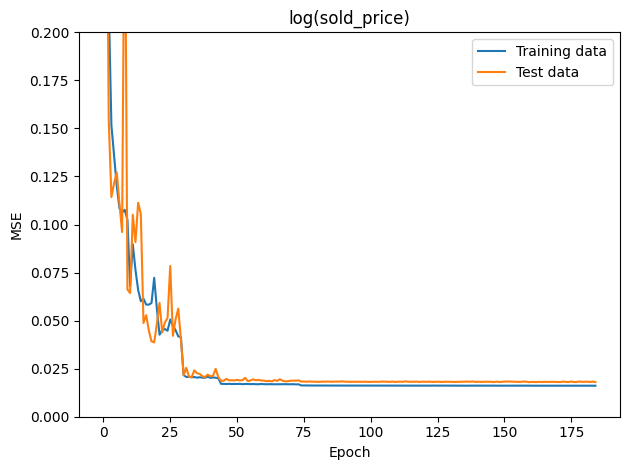

In [153]:
plot_convergence(Hist_soldPrice_shallow.history,  'sold_price', 'Shallow_drop0', dropLR = True )

In [126]:
%%time
Hist_m2Price_shallow = Shallow_m2Price.fit(X_train_m2Price, y_train_m2Price,
            validation_data=(X_test_m2Price, y_test_m2Price),
            verbose=0, 
            epochs=200,
            callbacks =[reduce_lr, early_stopping])

CPU times: total: 19.2 s
Wall time: 1min 55s


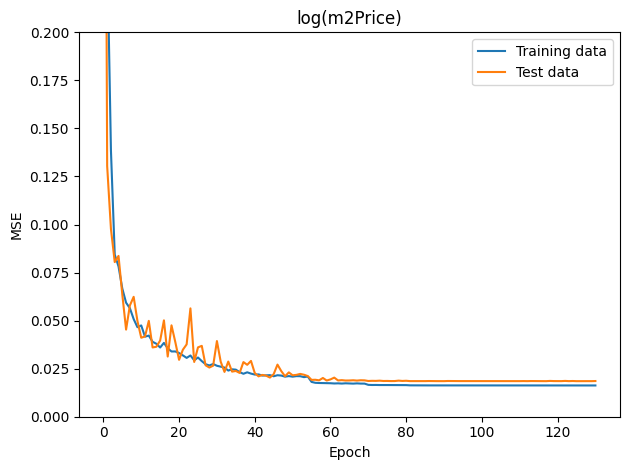

In [154]:
plot_convergence(Hist_m2Price_shallow.history,  'm2Price', 'Shallow_drop0', dropLR = True)

In [128]:
#We predict the training and test set for both models:
y_train_soldPrice_shallow_pred = Shallow_sold_price.predict(X_train_soldPrice).reshape(-1)
y_test_soldPrice_shallow_pred = Shallow_sold_price.predict(X_test_soldPrice).reshape(-1)

y_train_m2Price_shallow_pred = Shallow_m2Price.predict(X_train_m2Price).reshape(-1)
y_test_m2Price_shallow_pred = Shallow_m2Price.predict(X_test_m2Price).reshape(-1)

213/213 [==============================] - 0s 794us/step


LOGTRANSFORMED : LOG(sold_price)


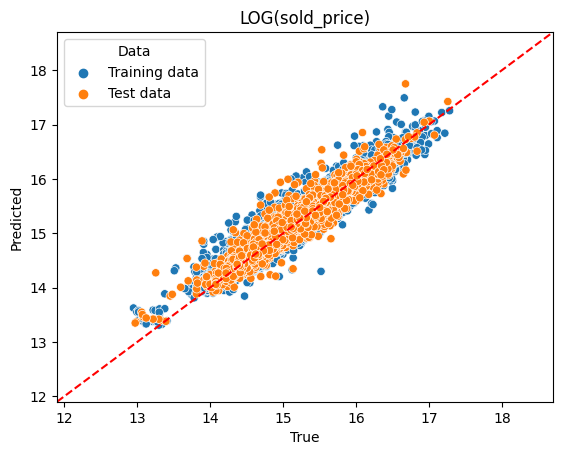

In [129]:
NN_plot(y_train_soldPrice, y_train_soldPrice_shallow_pred, y_test_soldPrice, y_test_soldPrice_shallow_pred, 'sold_price', 'Shallow_drop0')

LOGTRANSFORMED : LOG(m2Price_WA)


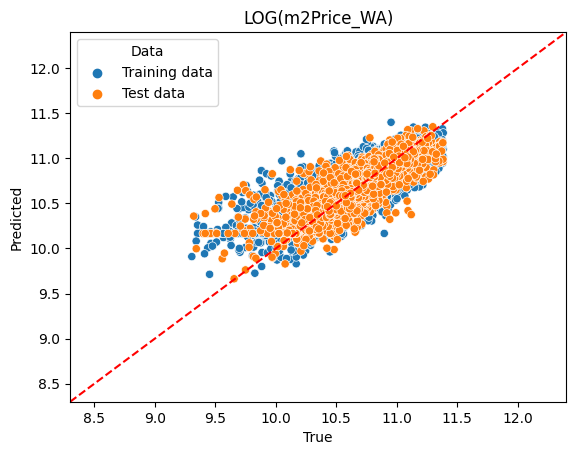

In [130]:
NN_plot(y_train_m2Price, y_train_m2Price_shallow_pred, y_test_m2Price, y_test_m2Price_shallow_pred, 'm2Price_WA', 'Shallow_drop0')

In [131]:
NN_res1_sold_price_shallow = results1(y_train_soldPrice, y_train_soldPrice_shallow_pred, y_test_soldPrice, y_test_soldPrice_shallow_pred, X_train_soldPrice, X_test_soldPrice, 'sold_price','NN Shallow_drop0 sold_price', ln=True)
NN_res1_sold_price_shallow

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Shallow\_drop0 sold\_price &    0.015967 &   0.017999 &    0.093278 &   0.096292 &       0.93712 &     0.929522 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Shallow_drop0 sold_price,0.015967,0.017999,0.093278,0.096292,0.93712,0.929522


In [132]:
NN_res1_m2Price_shallow = results1(y_train_m2Price, y_train_m2Price_shallow_pred, y_test_m2Price, y_test_m2Price_shallow_pred, X_train_m2Price, X_test_m2Price, 'm2Price','NN Shallow_drop0 m2Price', ln=True)
NN_res1_m2Price_shallow

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Shallow\_drop0 m2Price &    0.016232 &   0.018494 &    0.093601 &   0.097419 &      0.751515 &     0.722624 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Shallow_drop0 m2Price,0.016232,0.018494,0.093601,0.097419,0.751515,0.722624


In [133]:
NN_res2_sold_price_Shallow = result2(y_test_soldPrice, y_test_soldPrice_shallow_pred, X_test_soldPrice, 'sold_price','NN Shallow_drop0 sold_price',   compare_w_m2Price = False)
NN_res2_sold_price_Shallow

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN Shallow\_drop0 sold\_price &              9.86 &                7.26 &        63.69 &        81.02 &        90.18 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1351327956.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN Shallow_drop0 sold_price,9.856265,7.256322,63.693893,81.015453,90.183959


In [134]:

NN_res2_m2Price_Shallow = result2(y_test_m2Price, y_test_m2Price_shallow_pred, X_test_m2Price, 'm2Price','NN Shallow_drop0 m2Price')
NN_res2_m2Price_Shallow

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN Shallow\_drop0 m2Price &             10.02 &                7.28 &        63.37 &        80.54 &        89.57 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1351327956.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN Shallow_drop0 m2Price,10.017601,7.28079,63.370125,80.544518,89.565857


In [135]:
#We try to compare the sold_price to the m2Price, by divide the predicted soldPrice to a m2Price
results1(y_train_soldPrice, y_train_soldPrice_shallow_pred, y_test_soldPrice, y_test_soldPrice_shallow_pred, X_train_soldPrice, X_test_soldPrice, 'sold_price','NN Shallow_drop0 sold_price', ln=True, compare_w_m2Price=True)

#The MSE and MAE are close to the same as the Normal Result for Sold_price
#But the R^2 value drops a lot. 

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Shallow\_drop0 sold\_price &    0.015967 &   0.017999 &    0.093278 &   0.096292 &      0.755568 &     0.730045 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Shallow_drop0 sold_price,0.015967,0.017999,0.093278,0.096292,0.755568,0.730045


In [136]:
#We try to compare the sold_price to the m2Price, by divide the predicted soldPrice to a m2Price
result2(y_test_soldPrice, y_test_soldPrice_shallow_pred, X_test_soldPrice, 'sold_price','NN Shallow_drop0 sold_price',   compare_w_m2Price = True)

#THIS IS THE SAME AS THE NORMAL SOLD_PRICE RESULT
#MAKES SENSE SINCE IT IS ONLY SCALED DOWN

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN Shallow\_drop0 sold\_price &              9.86 &                7.26 &        63.69 &        81.02 &        90.18 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1351327956.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN Shallow_drop0 sold_price,9.856265,7.256322,63.693893,81.015453,90.183959


* ## Deep Nural Network


In [137]:
Deep_sold_price = SimpleNeuralNetwork(n_hiddenLayers=20, n_neurons = 50 ,XTrain = X_train_soldPrice, learning_rate = 0.01)

Deep_m2Price = SimpleNeuralNetwork(n_hiddenLayers=20, n_neurons = 50 ,XTrain = X_train_m2Price, learning_rate = 0.01)

In [138]:
Deep_sold_price.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 89)               179       
 tion)                                                           
                                                                 
 dense_24 (Dense)            (None, 50)                4500      
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dense_26 (Dense)            (None, 50)                2550      
                                                                 
 dense_27 (Dense)            (None, 50)                2550      
                                                                 
 dense_28 (Dense)            (None, 50)                2550      
                                                     

In [155]:
Deep_m2Price.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliza  (None, 88)               177       
 tion)                                                           
                                                                 
 dense_45 (Dense)            (None, 50)                4450      
                                                                 
 dense_46 (Dense)            (None, 50)                2550      
                                                                 
 dense_47 (Dense)            (None, 50)                2550      
                                                                 
 dense_48 (Dense)            (None, 50)                2550      
                                                                 
 dense_49 (Dense)            (None, 50)                2550      
                                                     

In [140]:
%%time
Hist_soldPrice_Deep = Deep_sold_price.fit(X_train_soldPrice, y_train_soldPrice,
            validation_data=(X_test_soldPrice, y_test_soldPrice),
            verbose=0, 
            epochs=200,
            callbacks =[reduce_lr, early_stopping])

CPU times: total: 41.4 s
Wall time: 2min 20s


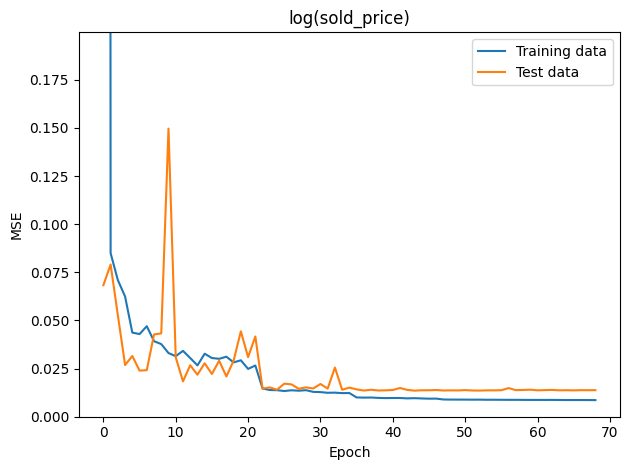

In [141]:
plot_convergence(Hist_soldPrice_Deep.history,  'sold_price', 'Deep_AllNorm_Drop0', dropLR = True)

In [142]:
%%time
Hist_m2Price_Deep = Deep_m2Price.fit(X_train_m2Price, y_train_m2Price,
            validation_data=(X_test_m2Price, y_test_m2Price),
            verbose=0, 
            epochs=200,
            callbacks =[reduce_lr, early_stopping])

CPU times: total: 29.2 s
Wall time: 1min 53s


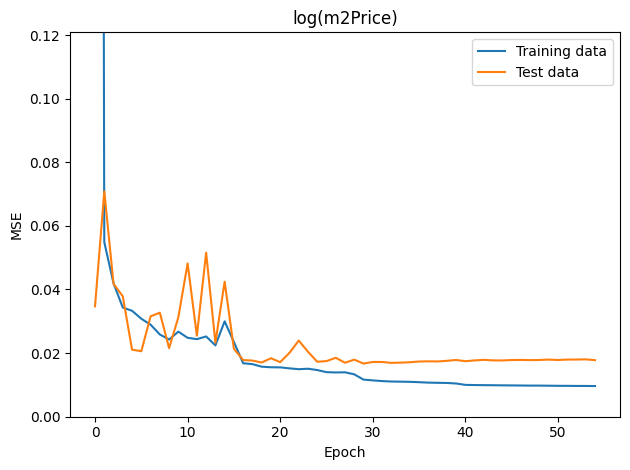

In [143]:
plot_convergence(Hist_m2Price_Deep.history,  'm2Price', 'Deep_AllNorm_Drop0', dropLR = True)

In [144]:
#We predict the training and test set for both models:
y_train_soldPrice_Deep_pred = Deep_sold_price.predict(X_train_soldPrice).reshape(-1)
y_test_soldPrice_Deep_pred = Deep_sold_price.predict(X_test_soldPrice).reshape(-1)

y_train_m2Price_Deep_pred = Deep_m2Price.predict(X_train_m2Price).reshape(-1)
y_test_m2Price_Deep_pred = Deep_m2Price.predict(X_test_m2Price).reshape(-1)

213/213 [==============================] - 0s 1ms/step


LOGTRANSFORMED : LOG(sold_price)


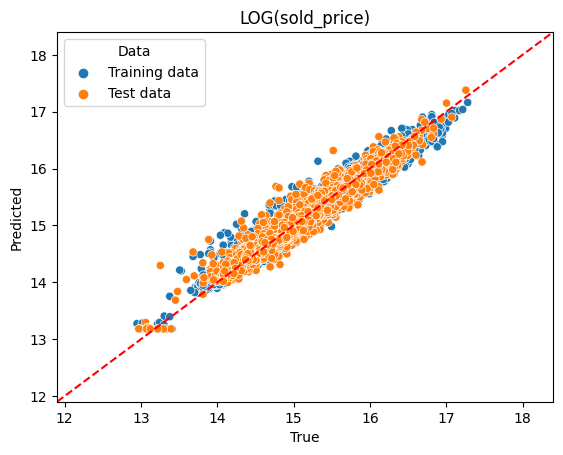

In [145]:
NN_plot(y_train_soldPrice, y_train_soldPrice_Deep_pred, y_test_soldPrice, y_test_soldPrice_Deep_pred, 'sold_price', 'Deep_AllNorm_Drop0')

LOGTRANSFORMED : LOG(m2Price_WA)


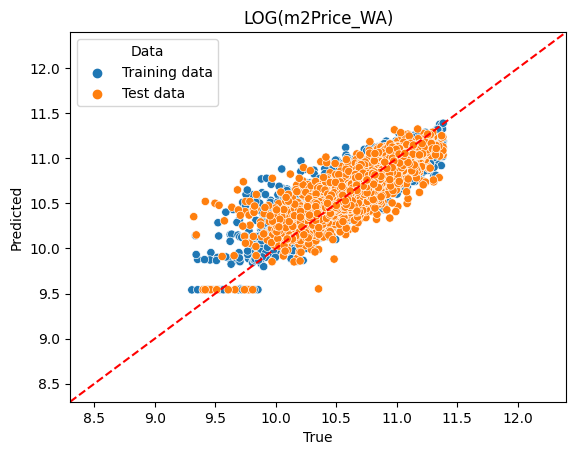

In [146]:
NN_plot(y_train_m2Price, y_train_m2Price_Deep_pred, y_test_m2Price, y_test_m2Price_Deep_pred, 'm2Price_WA', 'Deep_AllNorm_Drop0')

In [147]:
NN_res1_sold_price_Deep = results1(y_train_soldPrice, y_train_soldPrice_Deep_pred, y_test_soldPrice, y_test_soldPrice_Deep_pred, X_train_soldPrice, X_test_soldPrice, 'sold_price','NN Deep_AllNorm_Drop0 sold_price', ln=True)
NN_res1_sold_price_Deep

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Deep\_AllNorm\_Drop0 sold\_price &    0.009023 &   0.013545 &    0.070427 &    0.08472 &      0.964465 &     0.946962 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Deep_AllNorm_Drop0 sold_price,0.009023,0.013545,0.070427,0.08472,0.964465,0.946962


In [148]:
NN_res1_m2Price_Deep = results1(y_train_m2Price, y_train_m2Price_Deep_pred, y_test_m2Price, y_test_m2Price_Deep_pred, X_train_m2Price, X_test_m2Price, 'm2Price','NN Deep_AllNorm_Drop0 m2Price', ln=True)
NN_res1_m2Price_Deep

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Deep\_AllNorm\_Drop0 m2Price &    0.011023 &   0.016712 &    0.077702 &   0.091504 &      0.831255 &     0.749354 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Deep_AllNorm_Drop0 m2Price,0.011023,0.016712,0.077702,0.091504,0.831255,0.749354


In [149]:
NN_res2_sold_price_Deep = result2(y_test_soldPrice, y_test_soldPrice_Deep_pred, X_test_soldPrice, 'sold_price','NN Deep_AllNorm_Drop0 sold_price',   compare_w_m2Price = False)
NN_res2_sold_price_Deep


\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN Deep\_AllNorm\_Drop0 sold\_price &              8.57 &                6.44 &        68.77 &        84.97 &        92.76 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1351327956.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN Deep_AllNorm_Drop0 sold_price,8.565737,6.438881,68.771155,84.974246,92.759382


In [150]:

NN_res2_m2Price_Deep = result2(y_test_m2Price, y_test_m2Price_Deep_pred, X_test_m2Price, 'm2Price','NN Deep_AllNorm_Drop0 m2Price')
NN_res2_m2Price_Deep

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN Deep\_AllNorm\_Drop0 m2Price &              9.33 &                6.76 &        66.77 &         82.8 &        91.14 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1351327956.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN Deep_AllNorm_Drop0 m2Price,9.32758,6.760322,66.769684,82.796174,91.140545


In [151]:
#We try to compare the sold_price to the m2Price, by divide the predicted soldPrice to a m2Price
results1(y_train_soldPrice, y_train_soldPrice_Deep_pred, y_test_soldPrice, y_test_soldPrice_Deep_pred, X_train_soldPrice, X_test_soldPrice, 'sold_price','NN Deep_AllNorm_Drop0 sold_price', ln=True, compare_w_m2Price=True)


\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Deep\_AllNorm\_Drop0 sold\_price &    0.009023 &   0.013545 &    0.070427 &    0.08472 &      0.861867 &     0.796846 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_1492\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Deep_AllNorm_Drop0 sold_price,0.009023,0.013545,0.070427,0.08472,0.861867,0.796846


* ## HYPER PARAMETER TUNING

In [20]:
# HYPER PARAMETER TUNING - We run this manually two times. 
# One for each of our two responses:


target = 'sold_price'
#target = 'm2Price_WA'

In [21]:
hp_data = df.copy() #We take a copy of the df. 


#We remove the different price variable in our datase, so we dont need to make two DontUseVariables lists.   
if target=='sold_price':
    hp_data.drop(columns=['m2Price_WA'], inplace=True)
elif target=='m2Price_WA':
    hp_data.drop(columns=['sold_price', 'weighted_area'], inplace=True)
else:
    pass



#We delete alle the variables we will not use when modelling.
#We cant use year_renovated because of the missing values, so we also drop this. 

#Remeber it will automatically drop our target, so we dont have to do this here. 
DontUseVariables  = ['AVM_price', 'latest_prop_valuation', 'Year_Week', 'Year_Months', 'Year_Quarter', 'addressName', 'addressNumber', 'addressDoor', 'address_id', 'saleDate', 'saleYear']




#We prepare for LOG Tranformation name variable. 
target_ln = target + '_ln' #We create our new variable name
# We create our new variable where we use the natural log (ln).
hp_data[target_ln] = np.log(hp_data[target]) 

X_full_hp = hp_data.drop(columns=(DontUseVariables + [target, target_ln])) #We overwrite X, were we also drop the new column of our log(target)
y_full_np = hp_data[target_ln] #overwrite y if we are using our new target which is log transformation 


X_full_hp, y_full_np = shuffle(X_full_hp, y_full_np, random_state=2)

X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_full_hp, y_full_np, test_size=0.1, random_state = 2)




In [22]:
## Specifying where it has to search
hp_n_neurons = hp.HParam('n_neurons', hp.Discrete([10, 20, 30, 40, 50, 60, 70, 80]))
hp_n_hiddenLayers = hp.HParam('n_hiddenLayers', hp.Discrete([1, 2, 3, 4, 5, 6, 7]))
hp_activation = hp.HParam('activ', hp.Discrete(['relu', 'elu']))
hp_metric = 'mean_squared_error'
hp_normalize = hp.HParam('normalize_all_layers', hp.Discrete([True]))  #,False])) #We remove the False, since what we learned in the first run. And then We try again.
hp_DropRate = hp.HParam('DORate', hp.Discrete([0]))
hp_downSampling = hp.HParam('DownSampling', hp.Discrete([False, True]))
n_combo = len(hp_n_neurons.domain.values) * len(hp_n_hiddenLayers.domain.values) * len(hp_activation.domain.values) * len(hp_downSampling.domain.values) * len(hp_DropRate.domain.values)


In [23]:
## Preparing the log
with tf.summary.create_file_writer('logs_' + str(target) + '_SIDSTE_GANG_2/hparam_tuning/').as_default(): 
    hp.hparams_config(
    hparams=[hp_n_neurons, hp_n_hiddenLayers, hp_DropRate, hp_activation, hp_normalize, hp_downSampling],
    metrics=[hp.Metric(hp_metric, display_name='MSE')],
  )

In [24]:
## Actual model test

def train_test_model(hparams):
    lr = 0.01

    X_temp, X_val, y_temp, y_val = train_test_split(X_train_hp, y_train_hp, test_size = 0.2)
    model = TuneNeuralNetworks(n_neurons = hparams[hp_n_neurons], n_hiddenLayers=hparams[hp_n_hiddenLayers],
                        DORate = hparams[hp_DropRate], activ = hparams[hp_activation],
                        normalize_all_layers = hparams[hp_normalize], learning_rate = lr, dataset=X_temp, init = "he_normal", lossFunc=hp_metric, DownSampling=hparams[hp_downSampling])

    model.fit(X_temp, y_temp,
            validation_split=0.1,
            verbose=0,
            epochs=200
            ,callbacks = [reduce_lr, early_stopping])
    return model.evaluate(x = X_val, y = y_val, verbose = 0)


In [25]:
## More logging
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        MSE = train_test_model(hparams)
        print(MSE)
        tf.summary.scalar(hp_metric, MSE, step=1)


In [26]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [27]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


In [28]:
###############################
### 19 hours took to run ######
###############################


# For mean_squared_error
# n_neurons : [10, 20, 30, 40, 50]                  #5 
# hp_n_hiddenLayers : [1, 5, 10, 20, 30, 40, 50]    #7
# hp_activation : ['relu', 'elu']                   #2
# hp_normalize : [False, True]                      #2
# hp_DropRate : [0.00, 0.10, 0.20]                  #3
#
#
# 5*7*2*2*3 = 420 models run
#

#1544 min 27 sec
#1. time
###################################
##### Run time for sold_price #####
###################################
######## 1607 min 20.9 sec ########
###################################
##### 26 hours 47 min 21 sec ######
###################################

#2. time. Came to the same result
###################################
##### Run time for sold_price #####
###################################
######## 1544 min 27.2 sec ########
###################################
##### 25 hours 44 min 27 sec ######
###################################


# HYPER PARAMETER TUNING - We run this manually two times. 
# For our two responses. 





#TRY TO GO DEEPER:
# For mean_squared_error
# n_neurons : [10, 20, 30, 40, 50]                  #5 
# hp_n_hiddenLayers : [1, 2, 3, 4, 5, 6, 7]         #7
# hp_activation : ['relu', 'elu']                   #2
# hp_normalize : [True]                             #1
# hp_DropRate : [0.0, 0.125, 0.25, 0.375, 0.5       #5
#
#
#
# 5*7*2*1*5 = 350 models run
#

#3. time. New Parameters
###################################
##### Run time for sold_price #####
###################################
######## 574 min 43.2 sec #########
###################################
###### 9 hours 34 min 27 sec ######
###################################



#AND DEEPER
# For mean_squared_error
# n_neurons : [10, 20, 30, 40, 50, 60, 70, 80]      #8 
# hp_n_hiddenLayers : [1, 2, 3, 4, 5, 6, 7]         #7
# hp_activation : ['relu', 'elu']                   #2
# hp_normalize : [True]                             #1
# hp_DropRate : [0.0]                               #1
# hp_downSampling : ['No', 'Yes']                   #2
#
# 8*7*2*1*1*2 = 224 models run
#
#4. time. New Parameters with Down Sampling
###################################
##### Run time for sold_price #####
###################################
######## 524 min 56.7 sec #########
###################################
###### 8 hours 44 min 57 sec ######
###################################


session_num = 1

for num_units in hp_n_neurons.domain.values:
    for num_hidden in hp_n_hiddenLayers.domain.values:
        for dropRate in hp_DropRate.domain.values: #We use dropout rates [0.0]
            for activation in hp_activation.domain.values:
                for normalize in hp_normalize.domain.values:
                    for downSampling in hp_downSampling.domain.values:
                        hparams = {
                                    hp_n_neurons: num_units,
                                    hp_n_hiddenLayers: num_hidden,
                                    hp_DropRate: dropRate,
                                    hp_activation: activation,
                                    hp_normalize: normalize,
                                    hp_downSampling: downSampling
                                }
                        run_name = "run-{}".format(session_num)
                        print('--- Starting trial: {}/{}'.format(run_name, n_combo))
                        print({h.name: hparams[h] for h in hparams})
                        run('logs_' + str(target) + '_SIDSTE_GANG_2/hparam_tuning/' + run_name, hparams) # comment out to avoid running the very slow grid search
                        print('{}% done'.format(round(session_num/n_combo * 100, 2)))
                        session_num += 1



--- Starting trial: run-1/224
{'n_neurons': 10, 'n_hiddenLayers': 1, 'DORate': 0, 'activ': 'elu', 'normalize_all_layers': True, 'DownSampling': False}
0.018054142594337463
0.45% done
--- Starting trial: run-2/224
{'n_neurons': 10, 'n_hiddenLayers': 1, 'DORate': 0, 'activ': 'elu', 'normalize_all_layers': True, 'DownSampling': True}
0.01607620343565941
0.89% done
--- Starting trial: run-3/224
{'n_neurons': 10, 'n_hiddenLayers': 1, 'DORate': 0, 'activ': 'relu', 'normalize_all_layers': True, 'DownSampling': False}
0.016926970332860947
1.34% done
--- Starting trial: run-4/224
{'n_neurons': 10, 'n_hiddenLayers': 1, 'DORate': 0, 'activ': 'relu', 'normalize_all_layers': True, 'DownSampling': True}
0.018805300816893578
1.79% done
--- Starting trial: run-5/224
{'n_neurons': 10, 'n_hiddenLayers': 2, 'DORate': 0, 'activ': 'elu', 'normalize_all_layers': True, 'DownSampling': False}
0.015468105673789978
2.23% done
--- Starting trial: run-6/224
{'n_neurons': 10, 'n_hiddenLayers': 2, 'DORate': 0, 'act

In [ ]:
# HYPER PARAMETER TUNING - We run this manually two times. 
# One for each of our two responses:


#target = 'sold_price'
target = 'm2Price_WA'
hp_data = df.copy() #We take a copy of the df. 


#We remove the different price variable in our datase, so we dont need to make two DontUseVariables lists.   
if target=='sold_price':
    hp_data.drop(columns=['m2Price_WA'], inplace=True)
elif target=='m2Price_WA':
    hp_data.drop(columns=['sold_price', 'weighted_area'], inplace=True)
else:
    pass



#We delete alle the variables we will not use when modelling.
#We cant use year_renovated because of the missing values, so we also drop this. 

#Remeber it will automatically drop our target, so we dont have to do this here. 
DontUseVariables  = ['AVM_price', 'latest_prop_valuation', 'Year_Week', 'Year_Months', 'Year_Quarter', 'addressName', 'addressNumber', 'addressDoor', 'address_id', 'saleDate', 'saleYear']




#We prepare for LOG Tranformation name variable. 
target_ln = target + '_ln' #We create our new variable name
# We create our new variable where we use the natural log (ln).
hp_data[target_ln] = np.log(hp_data[target]) 

X_full_hp = hp_data.drop(columns=(DontUseVariables + [target, target_ln])) #We overwrite X, were we also drop the new column of our log(target)
y_full_np = hp_data[target_ln] #overwrite y if we are using our new target which is log transformation 


X_full_hp, y_full_np = shuffle(X_full_hp, y_full_np, random_state=2)

X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_full_hp, y_full_np, test_size=0.1, random_state = 2)

## Specifying where it has to search
hp_n_neurons = hp.HParam('n_neurons', hp.Discrete([10, 20, 30, 40, 50]))
hp_n_hiddenLayers = hp.HParam('n_hiddenLayers', hp.Discrete([1, 2, 3, 4, 5, 6, 7]))
hp_activation = hp.HParam('activ', hp.Discrete(['relu', 'elu']))
hp_metric = 'mean_squared_error'
hp_normalize = hp.HParam('normalize_all_layers', hp.Discrete([True]))  #,False])) #We remove the False, since what we learned in the first run. And then We try again.
hp_DropRate = hp.HParam('DORate', hp.RealInterval(0., 0.5))
n_combo = len(hp_n_neurons.domain.values) * len(hp_n_hiddenLayers.domain.values) * len(hp_activation.domain.values) * len(hp_normalize.domain.values) * 5


## Preparing the log
with tf.summary.create_file_writer('logs_' + str(target) + '_SIDSTE_GANG/hparam_tuning/').as_default(): 
    hp.hparams_config(
    hparams=[hp_n_neurons, hp_n_hiddenLayers, hp_DropRate, hp_activation, hp_normalize],
    metrics=[hp.Metric(hp_metric, display_name='MSE')],
  )

## Actual model test

def train_test_model(hparams):
    lr = 0.01
    X_temp, X_val, y_temp, y_val = train_test_split(X_train_hp, y_train_hp, test_size = 0.2)
    model = TuneNeuralNetworks(n_neurons = hparams[hp_n_neurons], n_hiddenLayers=hparams[hp_n_hiddenLayers],
                        DORate = hparams[hp_DropRate], activ = hparams[hp_activation],
                        normalize_all_layers = hparams[hp_normalize], learning_rate = lr, dataset=X_temp, init = "he_normal", lossFunc=hp_metric)

    model.fit(X_temp, y_temp,
            validation_split=0.1,
            verbose=0,
            epochs=200
            ,callbacks = [reduce_lr, early_stopping])
    return model.evaluate(x = X_val, y = y_val, verbose = 0)

## More logging
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        MSE = train_test_model(hparams)
        print(MSE)
        tf.summary.scalar(hp_metric, MSE, step=1)

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

###############################
### 19 hours took to run ######
###############################


# For mean_squared_error
# n_neurons : [10, 20, 30, 40, 50]                  #5 
# hp_n_hiddenLayers : [1, 5, 10, 20, 30, 40, 50]    #7
# hp_activation : ['relu', 'elu']                   #2
# hp_normalize : [False, True]                      #2
# hp_DropRate : [0.00, 0.10, 0.20]                  #3
#
#
# 5*7*2*2*3 = 420 models run
#


#1. time
###################################
##### Run time for m2Price_WA #####
###################################
######## 1841 min  1.5 sec ########
###################################
##### 30 hours 41 min  2 sec ######
###################################

#2. time. Came to the same result
###################################
##### Run time for m2Price_WA #####
###################################
####### 2006 min  26.6 sec ########
###################################
#### 33 hours 26 min  27 sec ######
###################################




# HYPER PARAMETER TUNING - We run this manually two times. 
# For our two responses. 




session_num = 1

for num_units in hp_n_neurons.domain.values:
    for num_hidden in hp_n_hiddenLayers.domain.values:
        for dropRate in list(np.linspace(hp_DropRate.domain.min_value, hp_DropRate.domain.max_value, 5)): #We use dropout rates [0.0, 0.125, 0.25, 0.375, 0.5]
            for activation in hp_activation.domain.values:
                for normalize in hp_normalize.domain.values:
                    hparams = {
                                hp_n_neurons: num_units,
                                hp_n_hiddenLayers: num_hidden,
                                hp_DropRate: dropRate,
                                hp_activation: activation,
                                hp_normalize: normalize
                               }
                    run_name = "run-{}".format(session_num)
                    print('--- Starting trial: {}/{}'.format(run_name, n_combo))
                    print({h.name: hparams[h] for h in hparams})
                    run('logs_' + str(target) + '_SIDSTE_GANG/hparam_tuning/' + run_name, hparams) # comment out to avoid running the very slow grid search
                    print('{}% done'.format(round(session_num/n_combo * 100, 2)))
                    session_num += 1


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs_sold_price/hparam_tuning

* ### Models with our results from First hypertuning

In [ ]:
X_train_soldPrice, X_test_soldPrice, y_train_soldPrice, y_test_soldPrice = dataset(df, 'sold_price', 0.2)
X_train_m2Price, X_test_m2Price, y_train_m2Price, y_test_m2Price = dataset(df, 'm2Price_WA', 0.2)

In [ ]:
#So we go with Neurons = 50, Hidden Layers = 5, Activation function = ELU, Batch normalization = True, Dropout rate = 0\%.



model_soldPrice = TuneNeuralNetworks(n_hiddenLayers = 5, n_neurons = 50,
                activ = 'elu', init = "he_normal", lossFunc = 'mean_squared_error',
                learning_rate = 0.05, dataset = X_train_soldPrice, normalize_all_layers = True,
                DORate = 0)

In [ ]:
#We do the same for m2Price as we saw in TensorBoard

model_m2Price = TuneNeuralNetworks(n_hiddenLayers = 5, n_neurons = 50,
                activ = 'elu', init = "he_normal", lossFunc = 'mean_squared_error',
                learning_rate = 0.05, dataset = X_train_m2Price, normalize_all_layers = True,
                DORate = 0)

In [ ]:
model_soldPrice.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 89)               179       
 ion)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 89)                0         
                                                                 
 dense_12 (Dense)            (None, 50)                4500      
                                                                 
 batch_normalization_10 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 50)                0         
                                                                 
 dropout_11 (Dropout)        (None, 50)               

In [ ]:
model_m2Price.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 88)               177       
 ion)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 88)                0         
                                                                 
 dense_18 (Dense)            (None, 50)                4450      
                                                                 
 batch_normalization_15 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 50)                0         
                                                                 
 dropout_16 (Dropout)        (None, 50)               

In [ ]:
Hist_soldPrice = model_soldPrice.fit(X_train_soldPrice, y_train_soldPrice,
            validation_data=(X_test_soldPrice, y_test_soldPrice),
            verbose=1, 
            epochs=400,
            callbacks =[reduce_lr, early_stopping])

Epoch 1/400
850/850 [==============================] - 3s 3ms/step - loss: 1.7209 - val_loss: 0.0301 - lr: 0.0500
Epoch 2/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0766 - val_loss: 0.0321 - lr: 0.0500
Epoch 3/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0774 - val_loss: 0.0262 - lr: 0.0500
Epoch 4/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0699 - val_loss: 0.0391 - lr: 0.0500
Epoch 5/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0843 - val_loss: 0.0517 - lr: 0.0500
Epoch 6/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0769 - val_loss: 0.0645 - lr: 0.0500
Epoch 7/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0805 - val_loss: 0.1617 - lr: 0.0500
Epoch 8/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0692 - val_loss: 0.0283 - lr: 0.0500
Epoch 9/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0689 - val_

In [ ]:
Hist_m2Price = model_m2Price.fit(X_train_m2Price, y_train_m2Price,
            validation_data=(X_test_m2Price, y_test_m2Price),
            verbose=1, 
            epochs=400,
            callbacks = [reduce_lr, early_stopping])

Epoch 1/400
850/850 [==============================] - 4s 3ms/step - loss: 0.7748 - val_loss: 0.0762 - lr: 0.0500
Epoch 2/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0428 - val_loss: 0.0563 - lr: 0.0500
Epoch 3/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0427 - val_loss: 0.1041 - lr: 0.0500
Epoch 4/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0392 - val_loss: 0.0348 - lr: 0.0500
Epoch 5/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0444 - val_loss: 0.0508 - lr: 0.0500
Epoch 6/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0440 - val_loss: 0.0362 - lr: 0.0500
Epoch 7/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0364 - val_loss: 0.0245 - lr: 0.0500
Epoch 8/400
850/850 [==============================] - 2s 2ms/step - loss: 0.0381 - val_loss: 0.0227 - lr: 0.0500
Epoch 9/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0339 - val_

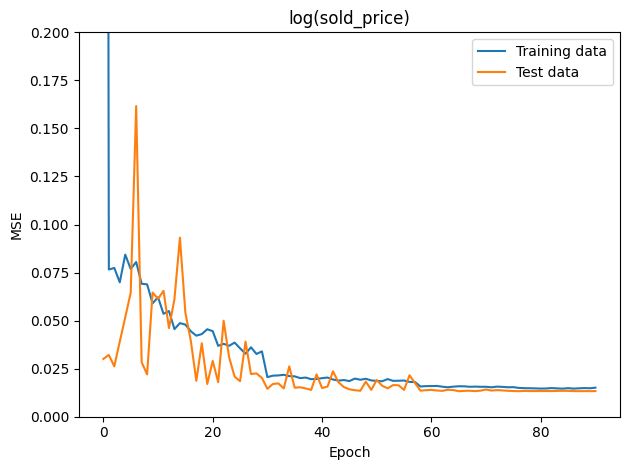

In [ ]:
plot_convergence(Hist_soldPrice.history, 'sold_price','HyperTuning', dropLR= True)

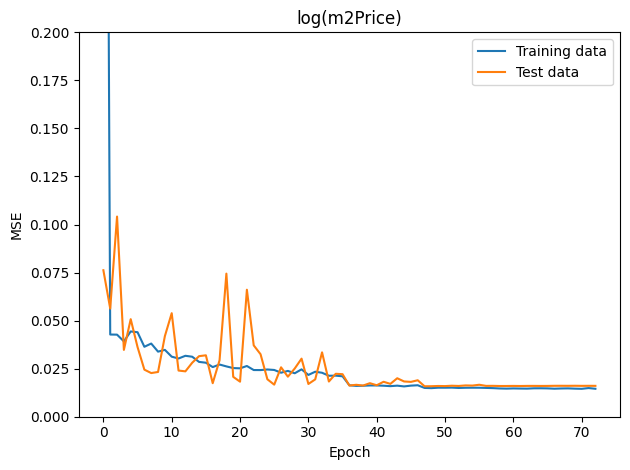

In [ ]:
plot_convergence(Hist_m2Price.history, 'm2Price','HyperTuning', dropLR= True)

In [ ]:
#We predict the training and test set for both models:
y_train_soldPrice_pred = model_soldPrice.predict(X_train_soldPrice).reshape(-1)
y_test_soldPrice_pred = model_soldPrice.predict(X_test_soldPrice).reshape(-1)

y_train_m2Price_pred = model_m2Price.predict(X_train_m2Price).reshape(-1)
y_test_m2Price_pred = model_m2Price.predict(X_test_m2Price).reshape(-1)


213/213 [==============================] - 0s 1ms/step


LOGTRANSFORMED : LOG(sold_price)


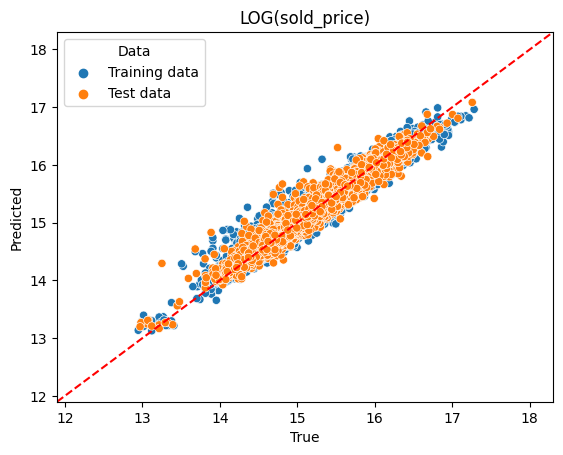

In [ ]:
NN_plot(y_train_soldPrice, y_train_soldPrice_pred, y_test_soldPrice, y_test_soldPrice_pred, 'sold_price','HyperTuning')

LOGTRANSFORMED : LOG(m2Price_WA)


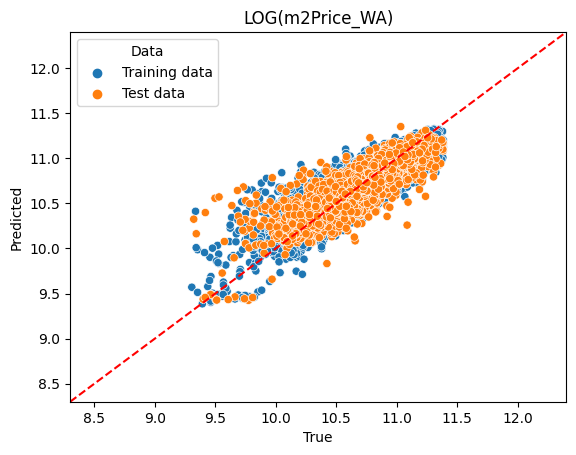

In [ ]:
NN_plot(y_train_m2Price, y_train_m2Price_pred, y_test_m2Price, y_test_m2Price_pred, 'm2Price_WA', 'HyperTuning')

In [ ]:
def predictions_dataset(yTrain, yTrain_pred, yTest, yTest_pred, XTrain, XTest):

    #We gather the data in a pandas dataframe
    y_Train_data = pd.DataFrame({'y_Predicted': yTrain_pred, 'y_True': yTrain, 'Residuals':(yTrain_pred - yTrain), 'Data': 'Training data'})
    y_Test_data = pd.DataFrame({'y_Predicted': yTest_pred, 'y_True': yTest, 'Residuals':(yTest_pred - yTest), 'Data': 'Test data'})
    #We store it toghether in one df. 
    y = pd.concat([y_Train_data, y_Test_data], ignore_index=True)

   
    X = pd.concat([XTrain, XTest], ignore_index=True)

    yX = pd.concat([y, X], axis=1)


    return yX

In [ ]:
sold = predictions_dataset(y_train_soldPrice, y_train_soldPrice_pred, y_test_soldPrice, y_test_soldPrice_pred, X_train_soldPrice, X_test_soldPrice)

m2 = predictions_dataset(y_train_m2Price, y_train_m2Price_pred, y_test_m2Price, y_test_m2Price_pred, X_train_m2Price, X_test_m2Price)



In [ ]:
# sold.to_csv('predicted_sold_price_03_Dec.csv', index = False)
# sold.to_excel("predicted_sold_price_03_Dec.xlsx")

# m2.to_csv('predicted_m2price_03_Dec.csv', index = False)
# m2.to_excel("predicted_m2price_03_Dec.xlsx")

* ### Result 1

In [ ]:
NN_res1_sold_price = results1(y_train_soldPrice, y_train_soldPrice_pred, y_test_soldPrice, y_test_soldPrice_pred, X_train_soldPrice, X_test_soldPrice, 'sold_price','NN sold_price' ,  ln=True)
NN_res1_sold_price

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN sold\_price &    0.010628 &   0.013261 &     0.07642 &   0.083405 &      0.958147 &     0.948075 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\1823047130.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN sold_price,0.010628,0.013261,0.07642,0.083405,0.958147,0.948075


In [ ]:
NN_res1_sold_price_compare = results1(y_train_soldPrice, y_train_soldPrice_pred, y_test_soldPrice, y_test_soldPrice_pred, X_train_soldPrice, X_test_soldPrice, 'sold_price','NN sold_price', ln=True,compare_w_m2Price=True)
NN_res1_sold_price_compare

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN sold\_price &    0.010628 &   0.013261 &     0.07642 &   0.083405 &      0.837305 &     0.801111 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\1823047130.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN sold_price,0.010628,0.013261,0.07642,0.083405,0.837305,0.801111


In [ ]:
NN_res1_m2Price = results1(y_train_m2Price, y_train_m2Price_pred, y_test_m2Price, y_test_m2Price_pred, X_train_m2Price, X_test_m2Price, 'm2Price','NN m2Price', ln=True)
NN_res1_m2Price

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN m2Price &    0.011264 &   0.015849 &    0.078624 &   0.089612 &      0.827573 &     0.762296 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\1823047130.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN m2Price,0.011264,0.015849,0.078624,0.089612,0.827573,0.762296


* ### Result 2

In [ ]:
NN_res2_sold_price = result2(y_test_soldPrice, y_test_soldPrice_pred, X_test_soldPrice, 'sold_price','NN sold_price',   compare_w_m2Price = False)
NN_res2_sold_price

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN sold\_price &              8.44 &                6.37 &        69.85 &         85.3 &        92.69 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\1056146340.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN sold_price,8.443553,6.373982,69.845475,85.298013,92.685798


In [ ]:
NN_res2_sold_price_compare = result2(y_test_soldPrice, y_test_soldPrice_pred, X_test_soldPrice, 'sold_price', 'NN sold_price', compare_w_m2Price = True)
NN_res2_sold_price_compare

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN sold\_price &              8.44 &                6.37 &        69.85 &         85.3 &        92.69 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\1056146340.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN sold_price,8.443553,6.373982,69.845475,85.298013,92.685798


In [ ]:
NN_res2_m2Price = result2(y_test_m2Price, y_test_m2Price_pred, X_test_m2Price, 'm2Price','NN m2Price')
NN_res2_m2Price

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN m2Price &               9.1 &                 6.7 &        67.06 &        83.59 &        91.91 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\1522514880.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN m2Price,9.104534,6.703936,67.064018,83.590876,91.905813


* ## Further Investigation results in models:

In [97]:
#So we go with Neurons = , Hidden Layers = , Activation function = , Batch normalization = True, Dropout rate = 0\%.
model_soldPrice2 = TuneNeuralNetworks(n_hiddenLayers = 6, n_neurons = 70,
                activ = 'relu', init = "he_normal", lossFunc = 'mean_squared_error',
                learning_rate = 0.01, dataset = X_train_soldPrice, normalize_all_layers = True,
                DORate = 0, DownSampling=True)

In [98]:
#We do the same for m2Price as we saw in TensorBoard

model_m2Price2 = TuneNeuralNetworks(n_hiddenLayers = 6, n_neurons = 70,
                activ = 'relu', init = "he_normal", lossFunc = 'mean_squared_error',
                learning_rate = 0.01, dataset = X_train_m2Price, normalize_all_layers = True,
                DORate = 0, DownSampling=True)

In [99]:
model_soldPrice2.summary()

Model: "sequential_232"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_232 (Normaliz  (None, 89)               179       
 ation)                                                          
                                                                 
 dropout_935 (Dropout)       (None, 89)                0         
                                                                 
 dense_1167 (Dense)          (None, 70)                6300      
                                                                 
 batch_normalization_935 (Ba  (None, 70)               280       
 tchNormalization)                                               
                                                                 
 activation_935 (Activation)  (None, 70)               0         
                                                                 
 dropout_936 (Dropout)       (None, 70)             

In [100]:
model_m2Price2.summary()

Model: "sequential_233"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_233 (Normaliz  (None, 88)               177       
 ation)                                                          
                                                                 
 dropout_941 (Dropout)       (None, 88)                0         
                                                                 
 dense_1174 (Dense)          (None, 70)                6230      
                                                                 
 batch_normalization_941 (Ba  (None, 70)               280       
 tchNormalization)                                               
                                                                 
 activation_941 (Activation)  (None, 70)               0         
                                                                 
 dropout_942 (Dropout)       (None, 70)             

In [101]:

Hist_soldPrice2 = model_soldPrice2.fit(X_train_soldPrice, y_train_soldPrice,
            validation_data=(X_test_soldPrice, y_test_soldPrice),
            verbose=1, 
            epochs=400,
            callbacks =[reduce_lr, early_stopping])

Epoch 1/400
850/850 [==============================] - 4s 3ms/step - loss: 8.4822 - val_loss: 0.1440 - lr: 0.0100
Epoch 2/400
850/850 [==============================] - 3s 3ms/step - loss: 0.0979 - val_loss: 0.0675 - lr: 0.0100
Epoch 3/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0741 - val_loss: 0.0321 - lr: 0.0100
Epoch 4/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0599 - val_loss: 0.0400 - lr: 0.0100
Epoch 5/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0597 - val_loss: 0.0386 - lr: 0.0100
Epoch 6/400
850/850 [==============================] - 3s 3ms/step - loss: 0.0527 - val_loss: 0.0341 - lr: 0.0100
Epoch 7/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0522 - val_loss: 0.0592 - lr: 0.0100
Epoch 8/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0510 - val_loss: 0.0658 - lr: 0.0100
Epoch 9/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0474 - val_

In [102]:

Hist_m2Price2 = model_m2Price2.fit(X_train_m2Price, y_train_m2Price,
            validation_data=(X_test_m2Price, y_test_m2Price),
            verbose=1, 
            epochs=400,
            callbacks = [reduce_lr, early_stopping])

Epoch 1/400
850/850 [==============================] - 5s 3ms/step - loss: 4.1437 - val_loss: 0.0667 - lr: 0.0100
Epoch 2/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0550 - val_loss: 0.0351 - lr: 0.0100
Epoch 3/400
850/850 [==============================] - 3s 3ms/step - loss: 0.0424 - val_loss: 0.0378 - lr: 0.0100
Epoch 4/400
850/850 [==============================] - 3s 3ms/step - loss: 0.0376 - val_loss: 0.0301 - lr: 0.0100
Epoch 5/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0347 - val_loss: 0.0344 - lr: 0.0100
Epoch 6/400
850/850 [==============================] - 3s 3ms/step - loss: 0.0329 - val_loss: 0.0272 - lr: 0.0100
Epoch 7/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0325 - val_loss: 0.0258 - lr: 0.0100
Epoch 8/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0311 - val_loss: 0.0238 - lr: 0.0100
Epoch 9/400
850/850 [==============================] - 2s 3ms/step - loss: 0.0312 - val_

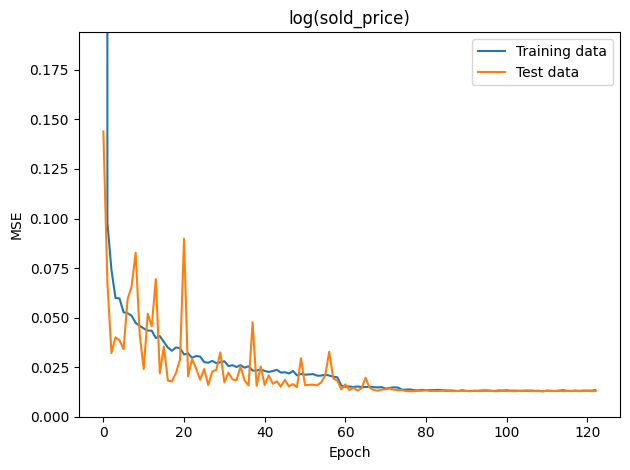

In [103]:
plot_convergence(Hist_soldPrice2.history, 'sold_price','Further HyperTuning', dropLR= True)

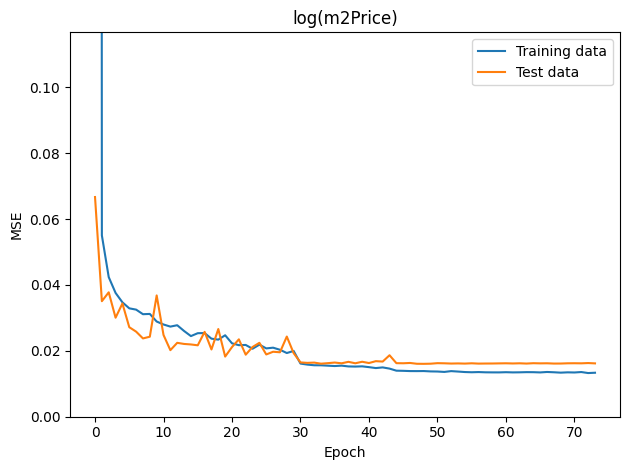

In [104]:
plot_convergence(Hist_m2Price2.history, 'm2Price','Further HyperTuning', dropLR= True)

In [105]:
#We predict the training and test set for both models:
y_train_soldPrice_pred2 = model_soldPrice2.predict(X_train_soldPrice).reshape(-1)
y_test_soldPrice_pred2 = model_soldPrice2.predict(X_test_soldPrice).reshape(-1)



213/213 [==============================] - 0s 1ms/step


In [106]:
y_train_m2Price_pred2 = model_m2Price2.predict(X_train_m2Price).reshape(-1)
y_test_m2Price_pred2 = model_m2Price2.predict(X_test_m2Price).reshape(-1)

213/213 [==============================] - 0s 1ms/step


LOGTRANSFORMED : LOG(sold_price)


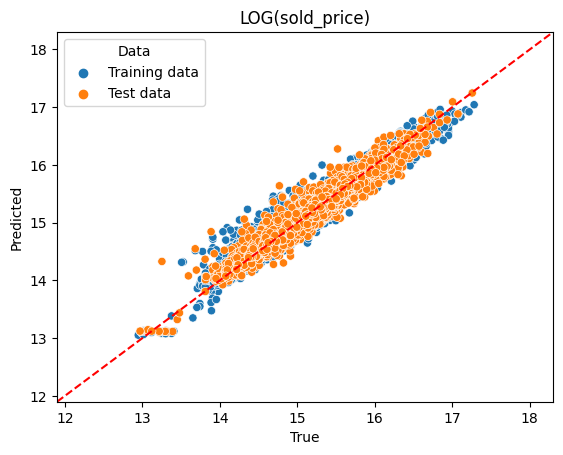

In [107]:
NN_plot(y_train_soldPrice, y_train_soldPrice_pred2, y_test_soldPrice, y_test_soldPrice_pred2, 'sold_price','Further HyperTuning')

LOGTRANSFORMED : LOG(m2Price_WA)


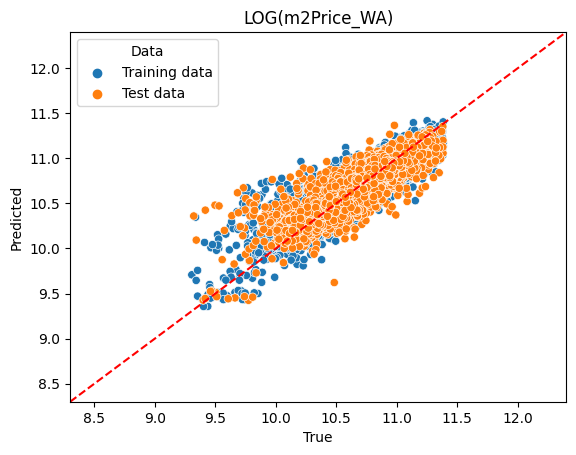

In [108]:
NN_plot(y_train_m2Price, y_train_m2Price_pred2, y_test_m2Price, y_test_m2Price_pred2, 'm2Price_WA', 'Further HyperTuning')

In [109]:
### Result 1
NN_res1_sold_price2 = results1(y_train_soldPrice, y_train_soldPrice_pred2, y_test_soldPrice, y_test_soldPrice_pred2, X_train_soldPrice, X_test_soldPrice, 'sold_price','NN Further sold_price' ,  ln=True)
NN_res1_sold_price2

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Further sold\_price &    0.009872 &   0.012858 &    0.073552 &   0.082043 &      0.961123 &      0.94965 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_10568\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Further sold_price,0.009872,0.012858,0.073552,0.082043,0.961123,0.94965


In [110]:

NN_res1_m2Price2 = results1(y_train_m2Price, y_train_m2Price_pred2, y_test_m2Price, y_test_m2Price_pred2, X_train_m2Price, X_test_m2Price, 'm2Price','NN Further m2Price', ln=True)
NN_res1_m2Price2

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
NN Further m2Price &    0.011486 &   0.016058 &    0.079442 &   0.090591 &      0.824167 &     0.759151 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_10568\1791528880.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
NN Further m2Price,0.011486,0.016058,0.079442,0.090591,0.824167,0.759151


In [111]:

NN_res2_sold_price2 = result2(y_test_soldPrice, y_test_soldPrice_pred2, X_test_soldPrice, 'sold_price','NN Further sold_price',   compare_w_m2Price = False)
NN_res2_sold_price2

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN Further sold\_price &              8.33 &                6.29 &        71.05 &         86.3 &        93.05 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_10568\1351327956.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN Further sold_price,8.32703,6.288726,71.052244,86.298749,93.053716


In [112]:
NN_res2_m2Price2 = result2(y_test_m2Price, y_test_m2Price_pred2, X_test_m2Price, 'm2Price','NN Further m2Price')
NN_res2_m2Price2

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
NN Further m2Price &              9.22 &                6.84 &        67.23 &        83.52 &        91.52 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_10568\1351327956.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
NN Further m2Price,9.217826,6.835369,67.225901,83.517292,91.523179


## Comparison

* ### AVM and Property valuation(SKAT)


We know that the AVM price is estimated in 2022, which therefore probably will be way off. But it is still fun to see.  

In [ ]:
def compare_loss(df_input, MSE_found_scalar, MAE_found_scalar ):

        df_ = df_input.copy()

        Val = df_[['AVM_price','latest_prop_valuation', 'sold_price', 'weighted_area']]
               
        
        #For m2Price:
        y_AVM_m2Price_pred = np.log(Val[~(Val['AVM_price'].isna())]['AVM_price']/Val[~(Val['AVM_price'].isna())]['weighted_area'])# All AVM prices observations
        y_AVM_m2Price = np.log(Val[~(Val['AVM_price'].isna())]['sold_price']/Val[~(Val['AVM_price'].isna())]['weighted_area']) #All AVM prices observations made to m2Prices but log transformed


        y_prop_val_m2Price = np.log(Val[~(Val['latest_prop_valuation'].isna())]['sold_price']/Val[~(Val['latest_prop_valuation'].isna())]['weighted_area']) # All Property valuations observations
        
        y_prop_val_m2Price_pred = np.log(Val[~(Val['latest_prop_valuation'].isna())]['latest_prop_valuation']/Val[~(Val['latest_prop_valuation'].isna())]['weighted_area']) # All Property valuations observations
        y_MSE_scaled_m2Price = np.log((Val[~(Val['latest_prop_valuation'].isna())]['latest_prop_valuation']*MSE_found_scalar)/Val[~(Val['latest_prop_valuation'].isna())]['weighted_area'])
        y_MAE_scaled_m2Price = np.log((Val[~(Val['latest_prop_valuation'].isna())]['latest_prop_valuation']*MAE_found_scalar)/Val[~(Val['latest_prop_valuation'].isna())]['weighted_area'])
        
        
        #For sold_price:
        y_AVM_pred = np.log(Val[~(Val['AVM_price'].isna())]['AVM_price'])# All AVM prices observations
        y_AVM_soldPrice = np.log(Val[~(Val['AVM_price'].isna())]['sold_price']) # All AVM prices observations 
        
        
        y_prop_val_soldPrice = np.log(Val[~(Val['latest_prop_valuation'].isna())]['sold_price']) # All Property valuations observations

        y_prop_val_pred = np.log(Val[~(Val['latest_prop_valuation'].isna())]['latest_prop_valuation']) # All Property valuations observations
        y_MSE_scaled_soldPrice = np.log((Val[~(Val['latest_prop_valuation'].isna())]['latest_prop_valuation']*MSE_found_scalar))
        y_MAE_scaled_soldPrice = np.log((Val[~(Val['latest_prop_valuation'].isna())]['latest_prop_valuation']*MAE_found_scalar))
        
        


        d = {'MSE':[1, (mean_squared_error(y_AVM_m2Price, y_AVM_m2Price_pred)), (mean_squared_error(y_prop_val_m2Price, y_prop_val_m2Price_pred)),
                (mean_squared_error(y_prop_val_m2Price, y_MSE_scaled_m2Price)), (mean_squared_error(y_prop_val_m2Price, y_MAE_scaled_m2Price)),
                1, (mean_squared_error(y_AVM_soldPrice, y_AVM_pred)), (mean_squared_error(y_prop_val_soldPrice, y_prop_val_pred)), 
                (mean_squared_error(y_prop_val_soldPrice, y_MSE_scaled_soldPrice)), (mean_squared_error(y_prop_val_soldPrice, y_MAE_scaled_soldPrice))], 

        'MAE':[1, (mean_absolute_error(y_AVM_m2Price, y_AVM_m2Price_pred)), (mean_absolute_error(y_prop_val_m2Price, y_prop_val_m2Price_pred)),
                (mean_absolute_error(y_prop_val_m2Price, y_MSE_scaled_m2Price)), (mean_absolute_error(y_prop_val_m2Price, y_MAE_scaled_m2Price)),
                1, (mean_absolute_error(y_AVM_soldPrice, y_AVM_pred)), (mean_absolute_error(y_prop_val_soldPrice, y_prop_val_pred)), 
                (mean_absolute_error(y_prop_val_soldPrice, y_MSE_scaled_soldPrice)), (mean_absolute_error(y_prop_val_soldPrice, y_MAE_scaled_soldPrice))],         
        '$R^2$':[1, (r2_score(y_AVM_m2Price, y_AVM_m2Price_pred)), (r2_score(y_prop_val_m2Price, y_prop_val_m2Price_pred)),
                (r2_score(y_prop_val_m2Price, y_MSE_scaled_m2Price)), (r2_score(y_prop_val_m2Price, y_MAE_scaled_m2Price)),
                1, (r2_score(y_AVM_soldPrice, y_AVM_pred)), (r2_score(y_prop_val_soldPrice, y_prop_val_pred)),
                (r2_score(y_prop_val_soldPrice, y_MSE_scaled_soldPrice)), (r2_score(y_prop_val_soldPrice, y_MAE_scaled_soldPrice))]}


        res = pd.DataFrame(data=d, index = ['log(m2Price)','AVM', 'SKAT', 'SKAT_MSE_Optimized','SKAT_MAE_Optimized','log(sold_price)','AVM', 'SKAT', 'SKAT_MSE_Optimized','SKAT_MAE_Optimized'])

        return res

In [ ]:
def Deviation(input, target, Model_name):
    df_ = input.copy()

    if target=='sold_price':
        df_['difference'] = abs(df_['sold_price']-df_[Model_name])
        df_['diffpercent'] = (df_['difference'] / df_['sold_price']) *100
    elif target=='m2Price':
        df_['difference'] = abs(df_['m2Price_WA']-df_[Model_name])
        df_['diffpercent'] = (df_['difference'] / df_['m2Price_WA']) *100
    else:
        pass


    mean_percent = np.mean(df_['diffpercent'])
    median_percent = np.median(df_['diffpercent'])
    within10 = (len(df_[df_['diffpercent'] < 10]) / len(df_)) *100
    within15 = (len(df_[df_['diffpercent'] < 15]) / len(df_)) *100
    within20 = (len(df_[df_['diffpercent'] < 20]) / len(df_)) *100

    res = pd.DataFrame({'Mean deviation %' : [mean_percent],
                        'Median deviation %' : [median_percent],
                        'Within 10 %': [within10],
                        'Within 15 %': [within15],
                        'Within 20 %': [within20]},
                        index = [Model_name] )
    return res
    

In [ ]:
def Compare_deviation(df_input, MSE_scalar, MAE_scalar):
    df_ = df_input.copy()
    Valuation = df_[['AVM_price','latest_prop_valuation', 'sold_price', 'weighted_area', 'm2Price_WA']]



    AVM_val = Valuation[~(Valuation['AVM_price'].isna())]
    PropVal = Valuation[~(Valuation['latest_prop_valuation'].isna())]
    PropVal['SKAT_MSE'] = PropVal['latest_prop_valuation']*MSE_scalar
    PropVal['SKAT_MAE'] = PropVal['latest_prop_valuation']*MAE_scalar


    AVM_val['AVM_m2Price'] = AVM_val['AVM_price']/AVM_val['weighted_area']
    PropVal['propVal_m2Price'] = PropVal['latest_prop_valuation']/PropVal['weighted_area']
    PropVal['SKAT_MSE_m2Price'] = PropVal['SKAT_MSE']/PropVal['weighted_area']
    PropVal['SKAT_MAE_m2Price'] = PropVal['SKAT_MAE']/PropVal['weighted_area']

    

    dev_AVM_m2 = Deviation(AVM_val, 'm2Price' ,'AVM_m2Price')
    dev_PropVal_m2 = Deviation(PropVal, 'm2Price' ,'propVal_m2Price')
    dev_MSE_m2 = Deviation(PropVal, 'm2Price' ,'SKAT_MSE_m2Price')
    dev_MAE_m2 = Deviation(PropVal,'m2Price' ,'SKAT_MAE_m2Price')

    dev_AVM = Deviation(AVM_val, 'sold_price' ,'AVM_price')
    dev_PropVal = Deviation(PropVal,'sold_price' ,'latest_prop_valuation')
    dev_MSE= Deviation(PropVal, 'sold_price' ,'SKAT_MSE')
    dev_MAE = Deviation(PropVal,'sold_price' ,'SKAT_MAE')

    deviation = round(pd.concat([dev_AVM_m2, dev_PropVal_m2, dev_MSE_m2, dev_MAE_m2, dev_AVM, dev_PropVal, dev_MSE, dev_MAE]), 2)
    None
    return deviation


In [ ]:
Valuation = df[['AVM_price','latest_prop_valuation', 'sold_price', 'weighted_area', 'm2Price_WA']]
y_prop_val_soldPrice = np.log(Valuation[~(Valuation['latest_prop_valuation'].isna())]['sold_price'])

In [ ]:
pd.options.mode.chained_assignment = None #We just turn of some simple warnings. It is just noise. 

In [ ]:
#We try to make a while loop, where we find an value we can scale the PropVal with so the MSE becomes better


run=True
MSE_scalar = 1.5
b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*MSE_scalar
c = mean_squared_error(y_prop_val_soldPrice, np.log(b))
while run==True:
    MSE_scalar = MSE_scalar + 0.00001
    b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*MSE_scalar

    if c > mean_squared_error(y_prop_val_soldPrice, np.log(b)):
        c = mean_squared_error(y_prop_val_soldPrice, np.log(b))
    else:
        MSE_scalar = MSE_scalar-0.00001
        print('Optimal scale for MSE is : ' + str(MSE_scalar))
        run=False
        break




Optimal scale for MSE is : 2.187490000004504


In [ ]:
# we also try to to it backwards:
run=True
a = 3
b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*a
c = mean_squared_error(y_prop_val_soldPrice, np.log(b))
while run==True:
    a = a - 0.00001
    b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*a

    if c > mean_squared_error(y_prop_val_soldPrice, np.log(b)):
        c = mean_squared_error(y_prop_val_soldPrice, np.log(b))
    else:
        a = a+0.00001
        print('Optimal scale for MSE is : ' + str(a))
        run=False
        break



Optimal scale for MSE is : 2.187489999994677


In [ ]:

## We try the same wit the MAE: 
#We try to make a while loop, where we find an value we can scale the PropVal with so the MAE becomes better

run=True
MAE_scalar = 1.5
b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*MAE_scalar
c = mean_absolute_error(y_prop_val_soldPrice, np.log(b))
while run==True:
    MAE_scalar = MAE_scalar + 0.00001
    b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*MAE_scalar

    if c > mean_absolute_error(y_prop_val_soldPrice, np.log(b)):
        c = mean_absolute_error(y_prop_val_soldPrice, np.log(b))
    else:
        MAE_scalar = MAE_scalar-0.00001
        print('Optimal scale for MAE is : ' + str(MAE_scalar))
        run=False
        break






Optimal scale for MAE is : 2.1735300000044124


In [ ]:
# we also try to to it backwards:
run=True
aa = 3
b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*aa
c = mean_absolute_error(y_prop_val_soldPrice, np.log(b))
while run==True:
    aa = aa - 0.00001
    b = Valuation[~(Valuation['latest_prop_valuation'].isna())]['latest_prop_valuation']*aa

    if c > mean_absolute_error(y_prop_val_soldPrice, np.log(b)):
        c = mean_absolute_error(y_prop_val_soldPrice, np.log(b))
    else:
        aa = aa+0.00001
        print('Optimal scale for MAE is : ' + str(aa))
        run=False
        break



Optimal scale for MAE is : 2.1735299999945856


In [ ]:
res = compare_loss(df, MSE_scalar, MAE_scalar )

In [ ]:
res

,MSE,MAE,$R^2$
log(m2Price),1.000000,1.000000,1.000000
AVM,0.109015,0.264018,-0.738060
SKAT,0.666267,0.784190,-9.575076
SKAT_MSE_Optimized,0.053560,0.168561,0.149888
SKAT_MAE_Optimized,0.053601,0.168464,0.149237
log(sold_price),1.000000,1.000000,1.000000
AVM,0.109015,0.264018,0.566990
SKAT,0.666267,0.784190,-1.615820
SKAT_MSE_Optimized,0.053560,0.168561,0.789719
SKAT_MAE_Optimized,0.053601,0.168464,0.789558


In [ ]:
print(res.to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &       MSE &       MAE &     \$R\textasciicircum 2\$ \\
\midrule
log(m2Price)       &  1.000000 &  1.000000 &  1.000000 \\
AVM                &  0.109015 &  0.264018 & -0.738060 \\
SKAT               &  0.666267 &  0.784190 & -9.575076 \\
SKAT\_MSE\_Optimized &  0.053560 &  0.168561 &  0.149888 \\
SKAT\_MAE\_Optimized &  0.053601 &  0.168464 &  0.149237 \\
log(sold\_price)    &  1.000000 &  1.000000 &  1.000000 \\
AVM                &  0.109015 &  0.264018 &  0.566990 \\
SKAT               &  0.666267 &  0.784190 & -1.615820 \\
SKAT\_MSE\_Optimized &  0.053560 &  0.168561 &  0.789719 \\
SKAT\_MAE\_Optimized &  0.053601 &  0.168464 &  0.789558 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\2766014194.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


In [ ]:
dev = Compare_deviation(df,  MSE_scalar, MAE_scalar)

In [ ]:
dev

,Mean deviation %,Median deviation %,Within 10 %,Within 15 %,Within 20 %
AVM_m2Price,32.10,26.53,22.00,29.54,36.47
propVal_m2Price,53.50,54.00,0.28,0.45,0.70
SKAT_MSE_m2Price,17.60,13.29,39.34,55.28,68.44
SKAT_MAE_m2Price,17.48,13.09,39.35,55.38,68.56
AVM_price,32.10,26.53,21.96,29.54,36.46
latest_prop_valuation,53.50,54.00,0.28,0.45,0.70
SKAT_MSE,17.60,13.29,39.34,55.28,68.44
SKAT_MAE,17.48,13.09,39.35,55.38,68.56


In [ ]:
print(dev.to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
AVM\_m2Price           &             32.10 &               26.53 &        22.00 &        29.54 &        36.47 \\
propVal\_m2Price       &             53.50 &               54.00 &         0.28 &         0.45 &         0.70 \\
SKAT\_MSE\_m2Price      &             17.60 &               13.29 &        39.34 &        55.28 &        68.44 \\
SKAT\_MAE\_m2Price      &             17.48 &               13.09 &        39.35 &        55.38 &        68.56 \\
AVM\_price             &             32.10 &               26.53 &        21.96 &        29.54 &        36.46 \\
latest\_prop\_valuation &             53.50 &               54.00 &         0.28 &         0.45 &         0.70 \\
SKAT\_MSE              &             17.60 &               13.29 &        39.34 &        55.28 &        68.44 \\
SKAT\_MAE              &             17.48 &               13.09 &

C:\Users\Mtubo\AppData\Local\Temp\ipykernel_19932\3556695935.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dev.to_latex(index=True))
